# Timelag Analysis of Synthesized AIA Emission from NOAA 1158

In [106]:
import os
import copy

import numpy as np
import scipy.signal
import scipy.ndimage
import dask
import dask.multiprocessing
import dask.distributed
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn.apionly as sns
from sunpy.map import Map,GenericMap
import astropy.units as u
import astropy.constants as const

import synthesizAR
from synthesizAR.model_ext import EbtelInterface,PowerLawScaledWaitingTimes,UniformHeating
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

In [2]:
ar_root = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/'

## Data Consolidation
First, load in all of the data for each channel at each timestep into a series of datacubes.

In [3]:
aia = InstrumentSDOAIA([0,5000]*u.s)

In [4]:
map_cubes = {chan['name']:None for chan in aia.channels}

In [5]:
for i,time in enumerate(aia.observing_time):
    print(time)
    for chan in aia.channels:
        tmp_map = Map(os.path.join(ar_root,'SDO_AIA/{}/map_t{:06d}.fits'.format(chan['name'],i)))
        if map_cubes[chan['name']] is None:
            map_cubes[chan['name']] = np.empty(tmp_map.data.shape + aia.observing_time.shape)
        map_cubes[chan['name']][:,:,i] = tmp_map.data

0.0 s
10.0 s
20.0 s
30.0 s
40.0 s
50.0 s
60.0 s
70.0 s
80.0 s
90.0 s
100.0 s
110.0 s
120.0 s
130.0 s
140.0 s
150.0 s
160.0 s
170.0 s
180.0 s
190.0 s
200.0 s
210.0 s
220.0 s
230.0 s
240.0 s
250.0 s
260.0 s
270.0 s
280.0 s
290.0 s
300.0 s
310.0 s
320.0 s
330.0 s
340.0 s
350.0 s
360.0 s
370.0 s
380.0 s
390.0 s
400.0 s
410.0 s
420.0 s
430.0 s
440.0 s
450.0 s
460.0 s
470.0 s
480.0 s
490.0 s
500.0 s
510.0 s
520.0 s
530.0 s
540.0 s
550.0 s
560.0 s
570.0 s
580.0 s
590.0 s
600.0 s
610.0 s
620.0 s
630.0 s
640.0 s
650.0 s
660.0 s
670.0 s
680.0 s
690.0 s
700.0 s
710.0 s
720.0 s
730.0 s
740.0 s
750.0 s
760.0 s
770.0 s
780.0 s
790.0 s
800.0 s
810.0 s
820.0 s
830.0 s
840.0 s
850.0 s
860.0 s
870.0 s
880.0 s
890.0 s
900.0 s
910.0 s
920.0 s
930.0 s
940.0 s
950.0 s
960.0 s
970.0 s
980.0 s
990.0 s
1000.0 s
1010.0 s
1020.0 s
1030.0 s
1040.0 s
1050.0 s
1060.0 s
1070.0 s
1080.0 s
1090.0 s
1100.0 s
1110.0 s
1120.0 s
1130.0 s
1140.0 s
1150.0 s
1160.0 s
1170.0 s
1180.0 s
1190.0 s
1200.0 s
1210.0 s
1220.0 s
1230

In [6]:
timelags = np.hstack([-aia.observing_time.value[1:][::-1],aia.observing_time.value])*aia.observing_time.unit

## Single-pixel/Pixel-averaged Light Curves

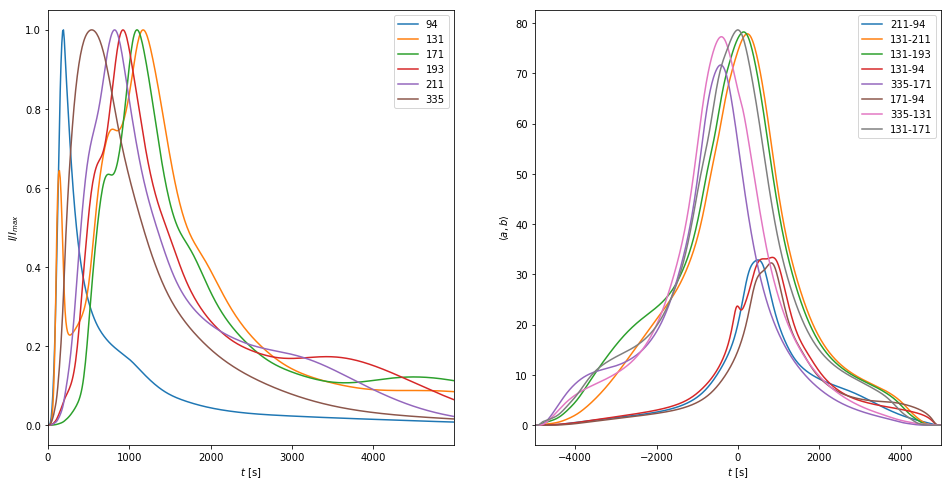

In [7]:
xbounds,ybounds = tmp_map.data_to_pixel(tmp_map.xrange,#u.Quantity((-280,-270),u.arcsec),
                                        tmp_map.yrange#u.Quantity((-191,-190),u.arcsec)
                                       )
xbounds = xbounds.value.astype(int)
ybounds = ybounds.value.astype(int)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
for chan in aia.channels:
    tmp_ts = map_cubes[chan['name']][ybounds[0]:ybounds[1],xbounds[0]:xbounds[1]].mean(axis=(0,1))
    tmp_ts /= tmp_ts.max()
    ax.plot(aia.observing_time,tmp_ts,label=chan['name'])
ax.set_xlim([0,aia.observing_time.value[-1]])
ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$I/I_{max}$')
ax.legend()
ax = fig.add_subplot(122)
for pairs in [(94,211),(211,131),(193,131),(94,131),(171,335),(94,171),(131,335),(171,131)]:
    hot_ts = map_cubes['{}'.format(pairs[0])][ybounds[0]:ybounds[1],xbounds[0]:xbounds[1]].mean(axis=(0,1))
    hot_ts /= hot_ts.max()
    cool_ts = map_cubes['{}'.format(pairs[1])][ybounds[0]:ybounds[1],xbounds[0]:xbounds[1]].mean(axis=(0,1))
    cool_ts /= cool_ts.max()
    corr = scipy.signal.correlate(cool_ts,hot_ts)
    ax.plot(timelags,corr,label=r'{}-{}'.format(pairs[1],pairs[0]))
ax.set_xlim([-aia.observing_time.value[-1],
             aia.observing_time.value[-1]])
ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$\langle a,b\rangle$')
ax.legend()

## Scaling to Whole AR

In [8]:
@dask.delayed
def correlate_timeseries(i,j,chan_a,chan_b):
    # convention is a-b channel pair from VK12
    # if variation in b follows variation in a, lag(a-b)>0
    # the function used follows the opposite convention so we switch the argument order
    timeseries_a = map_cubes[chan_a][i,j,:].copy()
    timeseries_a /= np.max(timeseries_a)
    timeseries_b = map_cubes[chan_b][i,j,:].copy()
    timeseries_b /= np.max(timeseries_b)
    ab_correlate = scipy.signal.correlate(timeseries_b,timeseries_a)
    if np.isnan(ab_correlate).any():
        delay = 0.
        max_cor = 0.
    else:
        delay = timelags[np.argmax(ab_correlate)].value
        max_cor = np.max(ab_correlate)
    return i,j,max_cor,delay

In [9]:
@dask.delayed
def build_corr_and_lag_arrays(coords_lag_list):
    ilist = np.array([cll[0] for cll in coords_lag_list])
    jlist = np.array([cll[1] for cll in coords_lag_list])
    cor_list = np.array([cll[2] for cll in coords_lag_list])
    lag_list = np.array([cll[3] for cll in coords_lag_list])
    cor_mat = np.empty(map_cubes['211'].shape[:2])
    lag_mat = np.empty(map_cubes['211'].shape[:2])
    cor_mat[ilist,jlist] = cor_list
    lag_mat[ilist,jlist] = lag_list
    return cor_mat,lag_mat

In [10]:
def mat2map(cormat,lagmat,chan_a,chan_b):
    tmp_meta = tmp_map.meta.copy()
    del tmp_meta['wavelnth']
    tmp_meta['chan_a'] = chan_a
    tmp_meta['chan_b'] = chan_b
    cormap = GenericMap(cormat,tmp_meta)
    tmp_meta['bunit'] = 's'
    lagmap = GenericMap(lagmat,tmp_meta)
    return cormap,lagmap

In [11]:
pixel_loc_list = [(i,j) for j in range(map_cubes['211'].shape[1]) for i in range(map_cubes['211'].shape[0])]

### 335-171

In [12]:
correlate_matrices_fnc = build_corr_and_lag_arrays(
    [correlate_timeseries(*ij,'335','171') for ij in pixel_loc_list]
)

In [13]:
cormap_335_171,lagmap_335_171 = mat2map(*correlate_matrices_fnc.compute(),'335','171')

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


### 171-131

In [14]:
correlate_matrices_fnc = build_corr_and_lag_arrays(
    [correlate_timeseries(*ij,'171','131') for ij in pixel_loc_list]
)

In [15]:
cormap_171_131,lagmap_171_131 = mat2map(*correlate_matrices_fnc.compute(),'171','131')

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


### 193-171

In [16]:
correlate_matrices_fnc = build_corr_and_lag_arrays(
    [correlate_timeseries(*ij,'193','171') for ij in pixel_loc_list]
)

In [17]:
cormap_193_171,lagmap_193_171 = mat2map(*correlate_matrices_fnc.compute(),'193','171')

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


## Visualization

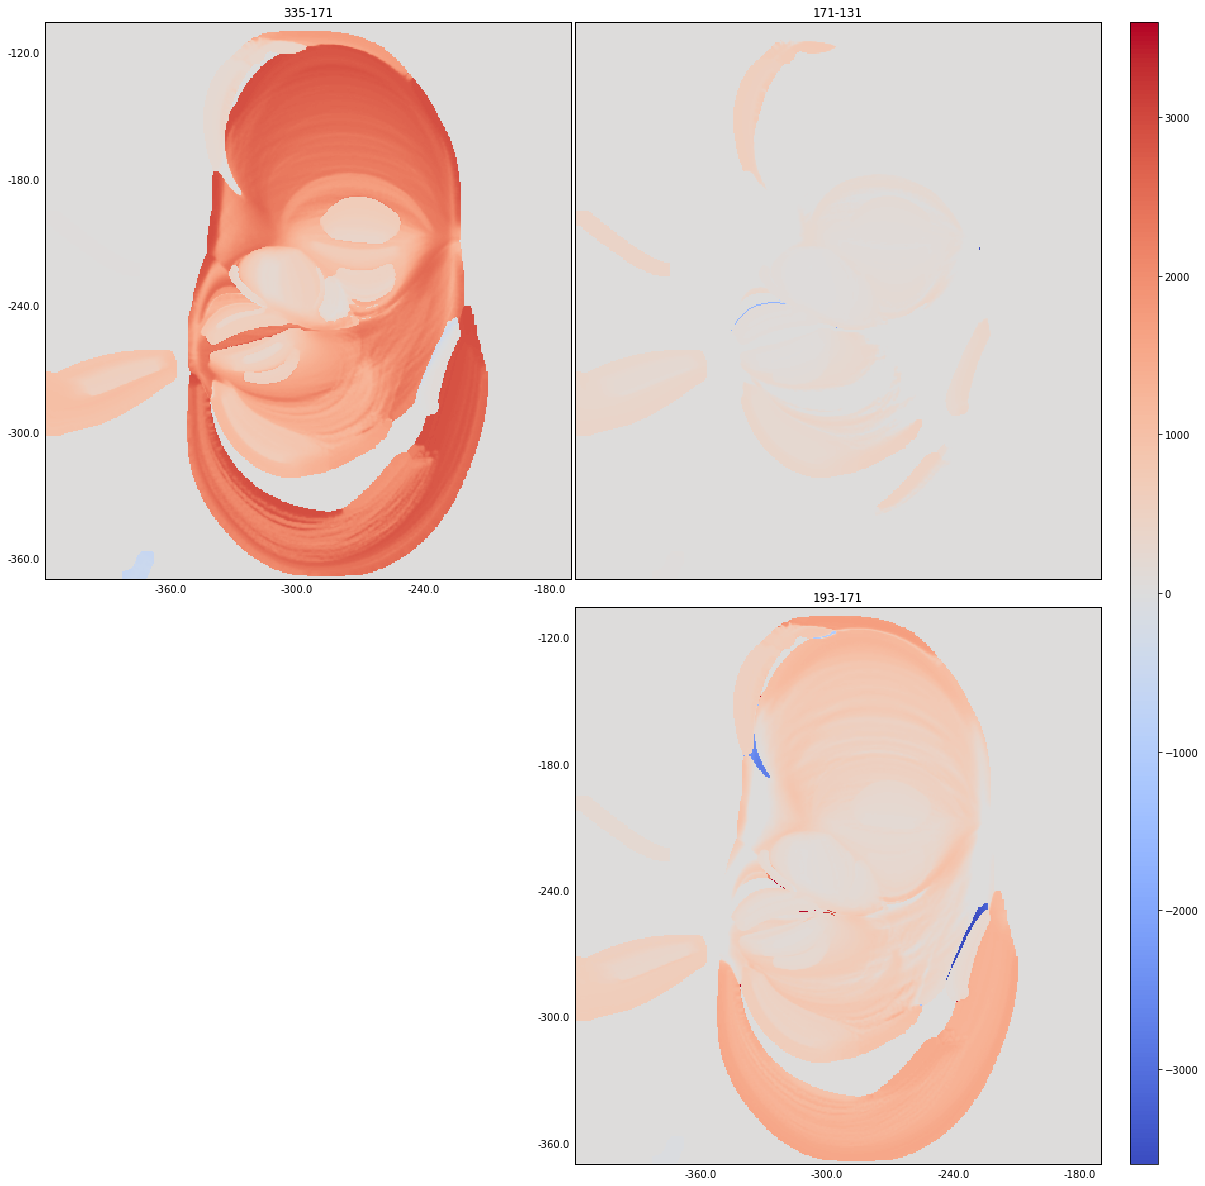

In [127]:
fig = plt.figure(figsize=(19,21))
cax = fig.add_axes([0.92,0.125,0.02,0.755])
plt.subplots_adjust(wspace=0.,hspace=0.05)
# 335-171
ax = fig.add_subplot(221,projection=lagmap_335_171)
im = lagmap_335_171.plot(annotate=False,axes=ax,
                         #norm=matplotlib.colors.SymLogNorm(1,
                         vmin=-3600,vmax=3600,
                         cmap=plt.get_cmap('coolwarm')
)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.set_title(r'{}-{}'.format(lagmap_335_171.meta['chan_a'],
                             lagmap_335_171.meta['chan_b']))
# 171-131
ax = fig.add_subplot(222,projection=lagmap_171_131)
im = lagmap_171_131.plot(annotate=False,axes=ax,
                         #norm=matplotlib.colors.SymLogNorm(1,
                         vmin=-3600,vmax=3600,
                         cmap=plt.get_cmap('coolwarm')
)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.coords[1].set_ticklabel_visible(False)
ax.coords[0].set_ticklabel_visible(False)
ax.set_title(r'{}-{}'.format(lagmap_171_131.meta['chan_a'],
                             lagmap_171_131.meta['chan_b']))
# 193-171
ax = fig.add_subplot(224,projection=lagmap_193_171)
im = lagmap_193_171.plot(annotate=False,axes=ax,
                         #norm=matplotlib.colors.SymLogNorm(1,
                         vmin=-3600,vmax=3600,
                         cmap=plt.get_cmap('coolwarm')
)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.set_title(r'{}-{}'.format(lagmap_193_171.meta['chan_a'],
                             lagmap_193_171.meta['chan_b']))
fig.colorbar(im,cax=cax)

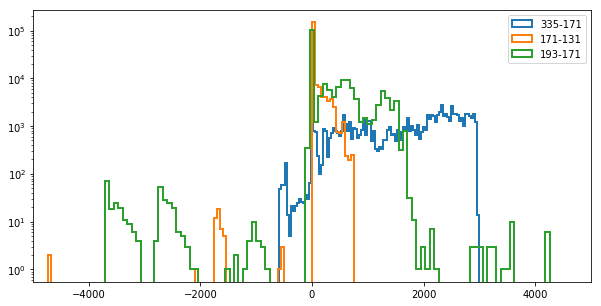

In [131]:
plt.figure(figsize=(10,5))
plt.hist(lagmap_335_171.data.flatten(),bins=100,histtype='step',lw=2,label='335-171')
plt.hist(lagmap_171_131.data.flatten(),bins=100,histtype='step',lw=2,label='171-131')
plt.hist(lagmap_193_171.data.flatten(),bins=100,histtype='step',lw=2,label='193-171')
plt.yscale('log')
plt.xlim([-5000,5000])
plt.legend()

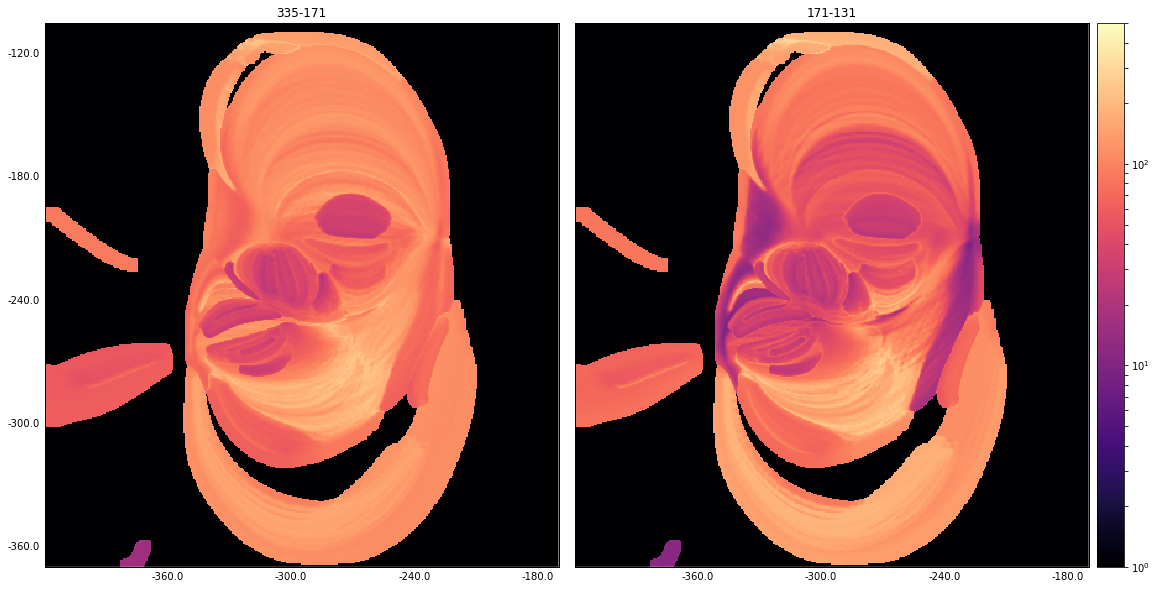

In [129]:
fig = plt.figure(figsize=(19,10))
cax = fig.add_axes([0.9,0.125,0.02,0.755])
plt.subplots_adjust(wspace=0.)
# 335-171
ax = fig.add_subplot(121,projection=cormap_335_171)
im = cormap_335_171.plot(annotate=False,axes=ax,
                         norm=matplotlib.colors.SymLogNorm(1e-2,vmin=1,vmax=5e2),
                         cmap=plt.get_cmap('magma')
)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.set_title(r'{}-{}'.format(cormap_335_171.meta['chan_a'],
                             cormap_335_171.meta['chan_b']))
# 171-131
ax = fig.add_subplot(122,projection=cormap_171_131)
im = cormap_171_131.plot(annotate=False,axes=ax,
                         norm=matplotlib.colors.SymLogNorm(1e-2,vmin=1,vmax=5e2),
                         cmap=plt.get_cmap('magma')
)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.coords[1].set_ticklabel_visible(False)
ax.set_title(r'{}-{}'.format(cormap_171_131.meta['chan_a'],
                             cormap_171_131.meta['chan_b']))
fig.colorbar(im,cax=cax)

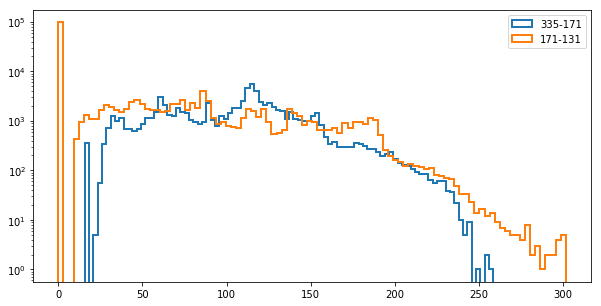

In [130]:
plt.figure(figsize=(10,5))
plt.hist(cormap_335_171.data.flatten(),bins=100,histtype='step',lw=2,label='335-171')
plt.hist(cormap_171_131.data.flatten(),bins=100,histtype='step',lw=2,label='171-131')
plt.yscale('log')
plt.legend()

In [ ]:
plt.plot(lagmap_335_171.data.flatten(),cormap_335_171.data.flatten(),'.',color=sns.color_palette('deep')[0],alpha=0.01)
plt.plot(lagmap_171_131.data.flatten(),cormap_171_131.data.flatten(),'.',color=sns.color_palette('deep')[2],alpha=0.01)
plt.xscale('log')
plt.xlim([10,5e3])

In [ ]:
def make_aia_frame(obs_time):
    obs_time_index = np.where(aia.observing_time==obs_time)[0][0]
    fn_prefix = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/'
    fig = plt.figure(figsize=(15,10))
    plt.subplots_adjust(wspace=0.,hspace=0.,top=0.95)
    for i,chan in enumerate(aia.channels):
        tmp = Map(os.path.join(fn_prefix,
                               'SDO_AIA/{}/map_t{:06d}.fits'.format(chan['name'],obs_time_index)))
        #tmp = tmp.submap(u.Quantity((-75,75),u.arcsec),
        #                 u.Quantity((-100,100),u.arcsec))
        ax = fig.add_subplot(2,3,i+1,projection=tmp)
        tmp.plot(annotate=False,
                 norm=matplotlib.colors.SymLogNorm(0.1,vmin=1,vmax=5e4))
        ax.coords[0].grid(alpha=0)
        ax.coords[1].grid(alpha=0)
        ax.coords[0].set_ticks_visible(False)
        ax.coords[1].set_ticks_visible(False)
        if i%3==0:
            ax.set_ylabel(r'solar-y [arcsec]',fontsize=14)
        else:
            ax.coords[1].set_ticklabel_visible(False)
        if i>2:
            ax.set_xlabel(r'solar-x [arcsec]',fontsize=14)
        else:
            ax.coords[0].set_ticklabel_visible(False)
        xtext,ytext = tmp.data_to_pixel(-230*u.arcsec,-130*u.arcsec)
        ax.text(xtext.value,ytext.value,
                r'${}$ $\mathrm{{\mathring{{A}}}}$'.format(chan['name']),color='w',fontsize=16)
    fig.suptitle(r'$t={:.0f}$ s'.format(obs_time.value),fontsize=14)


In [ ]:
make_aia_frame(2000*u.s)

## Comparison with EM Slopes

In [18]:
field = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/field_checkpoint/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-08-08 16:41:01,266 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-08-08 16:41:01,267 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-08-08 16:41:01,268 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-08-08 16:41:01,269 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-08-08 16:41:01,270 Parameters: cosmological_simulation   = 0.0


In [19]:
observer = synthesizAR.Observer(field,[aia],ds=field._convert_angle_to_length(1.2*u.arcsec))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/scipy/interpolate/_fitpack_impl.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/scipy/interpolate/_fitpack_impl.py:300: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [20]:
observer.build_detector_files('/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1158/singlepulse_simple/')

In [21]:
time_averaged_em_cube = None
for t in aia.observing_time:
    print(t)
    tmp_em_cube = observer.make_emission_measure_map(t,aia,temperature_bin_edges=10.**(np.arange(5.6, 7.1, 0.05))*u.K)
    if time_averaged_em_cube is None:
        time_averaged_em_cube = tmp_em_cube
    else:
        for mavg,mtmp in zip(time_averaged_em_cube,tmp_em_cube):
            mavg.data += mtmp.data
for m in time_averaged_em_cube:
    m.data /= aia.observing_time.shape[0]
    m.data = scipy.ndimage.gaussian_filter(m.data,(aia.channels[0]['gaussian_width']['y'].value,
                                                   aia.channels[0]['gaussian_width']['x'].value))

0.0 s
10.0 s
20.0 s
30.0 s
40.0 s
50.0 s
60.0 s
70.0 s
80.0 s
90.0 s
100.0 s
110.0 s
120.0 s
130.0 s
140.0 s
150.0 s
160.0 s
170.0 s
180.0 s
190.0 s
200.0 s
210.0 s
220.0 s
230.0 s
240.0 s
250.0 s
260.0 s
270.0 s
280.0 s
290.0 s
300.0 s
310.0 s
320.0 s
330.0 s
340.0 s
350.0 s
360.0 s
370.0 s
380.0 s
390.0 s
400.0 s
410.0 s
420.0 s
430.0 s
440.0 s
450.0 s
460.0 s
470.0 s
480.0 s
490.0 s
500.0 s
510.0 s
520.0 s
530.0 s
540.0 s
550.0 s
560.0 s
570.0 s
580.0 s
590.0 s
600.0 s
610.0 s
620.0 s
630.0 s
640.0 s
650.0 s
660.0 s
670.0 s
680.0 s
690.0 s
700.0 s
710.0 s
720.0 s
730.0 s
740.0 s
750.0 s
760.0 s
770.0 s
780.0 s
790.0 s
800.0 s
810.0 s
820.0 s
830.0 s
840.0 s
850.0 s
860.0 s
870.0 s
880.0 s
890.0 s
900.0 s
910.0 s
920.0 s
930.0 s
940.0 s
950.0 s
960.0 s
970.0 s
980.0 s
990.0 s
1000.0 s
1010.0 s
1020.0 s
1030.0 s
1040.0 s
1050.0 s
1060.0 s
1070.0 s
1080.0 s
1090.0 s
1100.0 s
1110.0 s
1120.0 s
1130.0 s
1140.0 s
1150.0 s
1160.0 s
1170.0 s
1180.0 s
1190.0 s
1200.0 s
1210.0 s
1220.0 s
1230

In [ ]:
fig = plt.figure(figsize=(8,8))
tmp_em_map = time_averaged_em_cube[19]
ax = fig.add_subplot(111,projection=tmp_em_map)
tmp_em_map.plot(annotate=False,axes=ax)
ax.set_title(r'$\log{{T}}={:.2f}-{:.2f}$'.format(np.log10(tmp_em_map.meta['temp_a']),np.log10(tmp_em_map.meta['temp_b'])))
plt.colorbar()

In [132]:
time_averaged_em_slopes = time_averaged_em_cube.make_slope_map(rsquared_tolerance=0.5,em_threshold=1e20*u.cm**(-5),
                                                               temperature_bounds=u.Quantity([1,2])*u.MK)

In [ ]:
plt.figure(figsize=(8,8))
time_averaged_em_slopes.plot(vmin=0,
                             vmax=3,
                             cmap=plt.get_cmap('viridis')
                            )
plt.colorbar()

In [133]:
flat_slopes = time_averaged_em_slopes.data.flatten()
lags_335_171 = lagmap_335_171.data.flatten()
lags_171_131 = lagmap_171_131.data.flatten()
lags_193_171 = lagmap_193_171.data.flatten()

In [123]:
plt.get_cmap('viridis').set_under(plt.get_cmap('viridis').colors[0])

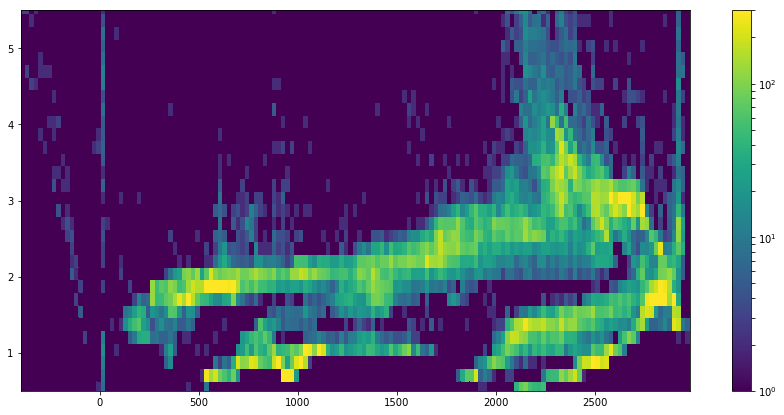

In [134]:
fig = plt.figure(figsize=(15,7))
ax = fig.gca()
_,xbins = np.histogram(lags_335_171[flat_slopes>0],bins=150)
_,ybins = np.histogram(flat_slopes[flat_slopes>0],bins=150)
hist2d,xedge,yedge = np.histogram2d(lags_335_171[flat_slopes>0],flat_slopes[flat_slopes>0],bins=(xbins,ybins),)
ymesh,xmesh = np.meshgrid((yedge[1:]+yedge[:-1])/2.,(xedge[1:]+xedge[:-1])/2.)
im = ax.pcolormesh(xmesh,ymesh,hist2d,norm=matplotlib.colors.SymLogNorm(1,vmin=1,vmax=300),cmap=plt.get_cmap('viridis'),)
#ax.set_xlim([np.min(lags_335_171[flat_slopes>0]),np.max(lags_335_171[flat_slopes>0])])
#ax.set_xlim([2000,2700])
ax.set_ylim([0.5,5.5])
fig.colorbar(im)

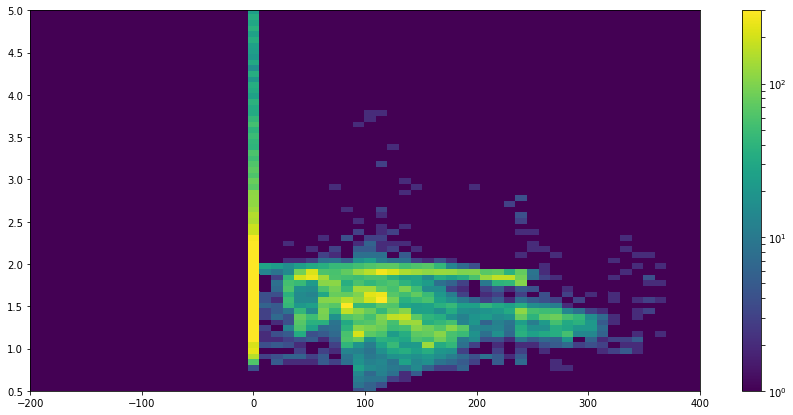

In [125]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
_,xbins = np.histogram(lags_171_131[flat_slopes>0],bins=500)
hist2d,xedge,yedge = np.histogram2d(lags_171_131[flat_slopes>0],flat_slopes[flat_slopes>0],bins=(xbins,ybins),)
ymesh,xmesh = np.meshgrid((yedge[1:]+yedge[:-1])/2.,(xedge[1:]+xedge[:-1])/2.)
im = ax.pcolormesh(xmesh,ymesh,hist2d,norm=matplotlib.colors.SymLogNorm(1,vmin=1,vmax=300),cmap=plt.get_cmap('viridis'),)
ax.set_xlim([-200,400])
ax.set_ylim([.5,5])
fig.colorbar(im)

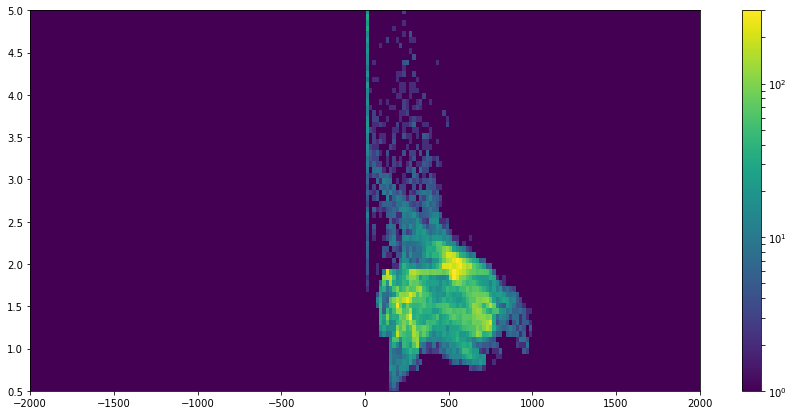

In [126]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
_,xbins = np.histogram(lags_193_171[flat_slopes>0],bins=400)
hist2d,xedge,yedge = np.histogram2d(lags_193_171[flat_slopes>0],flat_slopes[flat_slopes>0],bins=(xbins,ybins),)
ymesh,xmesh = np.meshgrid((yedge[1:]+yedge[:-1])/2.,(xedge[1:]+xedge[:-1])/2.)
im = ax.pcolormesh(xmesh,ymesh,hist2d,norm=matplotlib.colors.SymLogNorm(1,vmin=1,vmax=300),cmap=plt.get_cmap('viridis'),)
#ax.set_xlim([np.min(lags_193_171[flat_slopes>0]),np.max(lags_193_171[flat_slopes>0])])
ax.set_xlim([-2000,2000])
ax.set_ylim([0.5,5])
fig.colorbar(im)
#plt.tight_layout()

(0.5, 5)

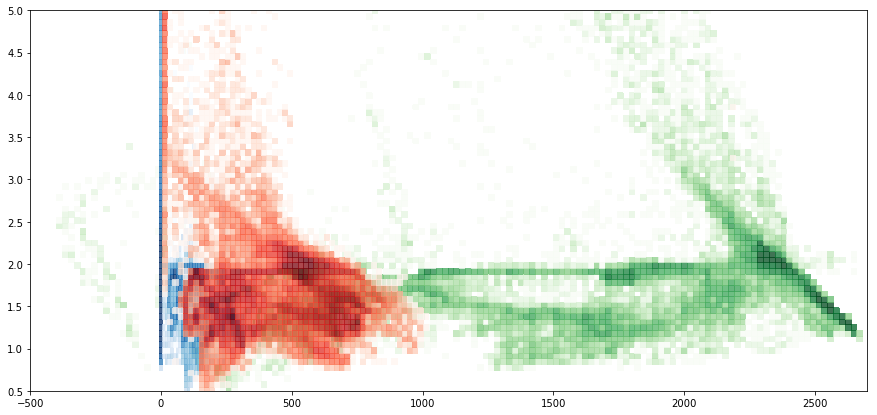

In [122]:
my_cmap = copy.copy(plt.get_cmap('viridis'))
my_cmap.set_under('w')
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
# 335-171
plt.get_cmap('Greens').set_under('w')
_,xbins = np.histogram(lags_335_171[flat_slopes>0],bins=150)
_,ybins = np.histogram(flat_slopes[flat_slopes>0],bins=150)
hist2d,xedge,yedge = np.histogram2d(lags_335_171[flat_slopes>0],flat_slopes[flat_slopes>0],bins=(xbins,ybins),)
ymesh,xmesh = np.meshgrid((yedge[1:]+yedge[:-1])/2.,(xedge[1:]+xedge[:-1])/2.)
hist2d = np.ma.masked_array(hist2d,hist2d==0.)
im = ax.pcolormesh(xmesh,ymesh,hist2d,
                   norm=matplotlib.colors.SymLogNorm(1,vmin=1,vmax=300),cmap=plt.get_cmap('Greens'),alpha=0.75)
#171-131
plt.get_cmap('Blues').set_under('w')
_,xbins = np.histogram(lags_171_131[flat_slopes>0],bins=500)
hist2d,xedge,yedge = np.histogram2d(lags_171_131[flat_slopes>0],flat_slopes[flat_slopes>0],bins=(xbins,ybins),)
hist2d = np.ma.masked_array(hist2d,hist2d==0.)
ymesh,xmesh = np.meshgrid((yedge[1:]+yedge[:-1])/2.,(xedge[1:]+xedge[:-1])/2.)
im = ax.pcolormesh(xmesh,ymesh,hist2d,
                   norm=matplotlib.colors.SymLogNorm(1,vmin=1,vmax=300),cmap=plt.get_cmap('Blues'),alpha=0.75)
# 193-171
plt.get_cmap('Reds').set_under('w')
_,xbins = np.histogram(lags_193_171[flat_slopes>0],bins=400)
hist2d,xedge,yedge = np.histogram2d(lags_193_171[flat_slopes>0],flat_slopes[flat_slopes>0],bins=(xbins,ybins),)
hist2d = np.ma.masked_array(hist2d,hist2d==0.)
ymesh,xmesh = np.meshgrid((yedge[1:]+yedge[:-1])/2.,(xedge[1:]+xedge[:-1])/2.)
im = ax.pcolormesh(xmesh,ymesh,hist2d,
                   norm=matplotlib.colors.SymLogNorm(1,vmin=1,vmax=300),cmap=plt.get_cmap('Reds'),alpha=0.75)
#labels
ax.set_xlim([-500,2700])
ax.set_ylim([.5,5])
#fig.colorbar(im)